In [1]:
import requests
from bs4 import BeautifulSoup

website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'lxml')

Scraping the url is next

In [2]:
parsed_table_data = []
myTable = soup.find('table',{'class':'wikitable sortable'})
rows = myTable.findAll('tr')
for row in rows:
    children = row.findChildren(recursive=False)
    row_text = []
    for child in children:
        clean_text = child.text
        #This is to discard reference/citation links
        clean_text = clean_text.split('&#91;')[0]
        #This is to clean the header row of the sort icons
        clean_text = clean_text.split('&#160;')[-1]
        clean_text = clean_text.strip()
        row_text.append(clean_text)
    parsed_table_data.append(row_text)


After cleaning the data, let's take a look at the obtained list:

In [3]:
parsed_table_data[0:5]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

Now let's convert it to a dataframe. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [4]:
import pandas as pd
columns_names = ['PostalCode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(parsed_table_data,columns = columns_names)
df = df.drop([0])
df.head()

,PostalCode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


Let's only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [5]:
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Not assigned
11,M9A,Etobicoke,Islington Avenue
12,M1B,Scarborough,Rouge
13,M1B,Scarborough,Malvern


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [6]:
 df.loc[df.Neighbourhood == 'Not assigned',['Borough']]['Borough']

9    Queen's Park
Name: Borough, dtype: object

In [7]:
df.loc[df.Neighbourhood == 'Not assigned',['Neighbourhood']] =  df.loc[df.Neighbourhood == 'Not assigned',['Borough']]['Borough']
df.head(10)

,PostalCode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Queen's Park
11,M9A,Etobicoke,Islington Avenue
12,M1B,Scarborough,Rouge
13,M1B,Scarborough,Malvern


If more than one neighborhood can exist in one postal code area, these will be combined into one row with the neighborhoods separated with a comma.

In [8]:
df = df.groupby(['PostalCode','Borough']).agg(lambda x: ','.join(set(x))).reset_index()

In [9]:
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek"
2,M1E,Scarborough,"Morningside,Guildwood,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Ionview,East Birchmount Park,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffside,Cliffcrest,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [10]:
df.shape

(103, 3)

I COULD NOT EXPLORE THE LAT, LONG USING GEOCODER
OVER_QUERY_LIMIT was returned

In [11]:
#!conda install -c conda-forge geocoder --yes
#import geocoder # import geocoder
#latitude = []
#longitude = []
#for postal_code in df['PostalCode']:
#    # initialize your variable to None
#    lat_lng_coords = None
#    # loop until you get the coordinates
#    while(lat_lng_coords is None):
#      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#      lat_lng_coords = g.latlng
#    latitude = lat_lng_coords[0]
#    longitude = lat_lng_coords[1]

Let's explore the lat and long using the CSV file

In [12]:
!wget -q -O 'Geospatial_Coordinates.csv' https://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [13]:
latlng_df = pd.read_csv('Geospatial_Coordinates.csv')
latlng_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now let's rename the column to match the PostalCode Column in the original dataframe before we merge them

In [14]:
latlng_df.columns = ['PostalCode','Latitude','Longitude']
latlng_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In the following step, we will use pandas to merge the two tables based on the Postal Code column

In [15]:
neighborhoods = pd.merge(df,latlng_df[['PostalCode','Latitude','Longitude']],on='PostalCode')
neighborhoods.head(10)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Ionview,East Birchmount Park,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside,Cliffcrest,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [16]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


Let's explore Toronto's neighbourhood and plot each neighbrouhood on the map

In [17]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.17.0                     py_0    conda-forge


In [18]:
# create map of Toronto using Toronto's latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto



### Get Venues including Coffee Shop Ratings - Save the resutls for further post processing
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
Get Venue ratings as well. This will help us determine the coffee shop ratings. Venues that do not have ratings will be marked as nan. 

The code was marked down and was run once only because of the limits Foursquare has on premium calls. We will re-load the results from the saved csv file.

Let's download the size of the resulting dataframe. Reason is that Foursquare will limit your API calls after you run the notebook couple of times. 
We will use the results from the saved dataset.

### Re-load the results

In [19]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_662ce83bb7d64302b35c576c37502c9f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='YLIVrxRRLp8DAohVi1Yn88BRxoohLllNSgJYgxZUaWI9',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_662ce83bb7d64302b35c576c37502c9f.get_object(Bucket='datascience-donotdelete-pr-rtc5zpexpyas92',Key='data_.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

toronto_venues = pd.read_csv(body)
cols =['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category','Venue Rating']
toronto_venues = toronto_venues[cols]
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
0,"Malvern,Rouge",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,NaN
1,"Rouge Hill,Port Union,Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,NaN
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,NaN
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,NaN
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa,NaN


Some of the neighborhoods did not return enough data from Foursquare, we will proceed by removing those neighbrohoods from the list.

In [20]:
toronto_venues_grouped = toronto_venues.groupby('Neighborhood').count()
toronto_venues_grouped.reset_index(inplace=True)
missing_set = list(set(neighborhoods['Neighbourhood']) - set(toronto_venues_grouped['Neighborhood']))
missing_df = neighborhoods.loc[neighborhoods['Neighbourhood'].isin(missing_set)]

missing_df

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",43.763573,-79.188711
6,M1K,Scarborough,"Ionview,East Birchmount Park,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside,Cliffcrest,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848
10,M1P,Scarborough,"Wexford Heights,Scarborough Town Centre,Dorset...",43.757410,-79.273304
11,M1R,Scarborough,"Wexford,Maryvale",43.750072,-79.295849
13,M1T,Scarborough,"Clarks Corners,Tam O'Shanter,Sullivan",43.781638,-79.304302


In [21]:
for hood in list(missing_df['Neighbourhood']):
    indx = neighborhoods.index[neighborhoods['Neighbourhood'] == hood]
    neighborhoods.drop(indx,inplace=True)

Let's check how many coffee shops are returned for each neighborhood

In [22]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
Neighborhood,,,,,,,
Agincourt,4,4,4,4,4,4,0
"Bathurst Manor,Downsview North,Wilson Heights",17,17,17,17,17,17,2
Bayview Village,4,4,4,4,4,4,1
Berczy Park,30,30,30,30,30,30,2
Business reply mail Processing Centre969 Eastern,17,17,17,17,17,17,0
"CFB Toronto,Downsview East",3,3,3,3,3,3,0
"Cabbagetown,St. James Town",30,30,30,30,30,30,4
Caledonia-Fairbanks,6,6,6,6,6,6,0
Canada Post Gateway Processing Centre,11,11,11,11,11,11,2


Let's find out how many of these coffee shops are Starbucks or Tim hortons

In [23]:
coffeeShop = toronto_venues[toronto_venues['Venue Category'] == 'Coffee Shop']
cafe = toronto_venues[toronto_venues['Venue Category'] == 'Café']

coffeeShops = pd.concat([coffeeShop,cafe])
coffeeShops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop,6.9
10,Woburn,43.770992,-79.216917,Tim Hortons,43.770827,-79.223078,Coffee Shop,6.2
24,"Kennedy Park,Ionview,East Birchmount Park",43.727929,-79.262029,Tim Hortons,43.726895,-79.266157,Coffee Shop,5.9
72,"Steeles East,Agincourt North,Milliken,L'Amorea...",43.815252,-79.284577,Lickety's,43.816136,-79.287944,Coffee Shop,NaN
79,"Steeles West,L'Amoreaux West",43.799525,-79.318389,Tim Hortons,43.798281,-79.318317,Coffee Shop,6.2


In [24]:
print('There are {} total coffee shops in the dataset.'.format(len(coffeeShops)))
coffeeShopsGrouped = coffeeShops.groupby('Venue').count()['Neighborhood']
#coffeeShopsGrouped.head()
coffeeShopsGroupedRating = coffeeShops.groupby('Venue').mean()['Venue Rating']
#coffeeShopsGrouped["Mean Rating"] = coffeeShopsGroupedRating
coffeeShopsGrouped = pd.concat([coffeeShopsGrouped, coffeeShopsGroupedRating], axis=1)
coffeeShopsGrouped.columns = ['Total',"Mean Rating"]

There are 156 total coffee shops in the dataset.


#### Let's check the total number of coffee shops 

In [25]:
coffeeShopsGrouped.sort_values(by='Total', ascending=False)

,Total,Mean Rating
Venue,,
Starbucks,24,7.450000
Tim Hortons,22,6.550000
Second Cup,5,6.320000
Aroma Espresso Bar,5,7.780000
Mos Mos Coffee,4,8.600000
Pilot Coffee Roasters,4,8.475000
Sam James Coffee Bar (SJCB),4,8.250000
Maman,3,8.500000
Balzac's Coffee,3,8.033333


#### Let's check the mean ratings of coffee shops 

In [26]:
coffeeShopsGrouped.sort_values(by='Mean Rating', ascending=False)

,Total,Mean Rating
Venue,,
Fahrenheit Coffee,1,9.300000
Boxcar Social,2,9.100000
Rooster Coffee,1,9.100000
Arvo,1,9.100000
Dineen Coffee,2,9.100000
The Moonbean Cafe,1,9.000000
Page One Cafe,1,9.000000
Contra Cafe,1,8.900000
Hailed Coffee,1,8.900000


In [27]:
# create map of Toronto's Coffee shops
map_toronto_coffee = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name, rating in zip(coffeeShops['Venue Latitude'], coffeeShops['Venue Longitude'], coffeeShops['Venue'], coffeeShops['Venue Rating']):
    if rating is np.nan:
        rating = 'na'
    label = '{}, {}'.format(name, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='brown',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_coffee)  

map_toronto_coffee

In [28]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Coffee Shop', 'Café'], axis=1, inplace=True)


toronto_onehot = toronto_onehot.iloc[0:coffeeShops.shape[0],:]
toronto_onehot['CoffeeShop Name'] = coffeeShops['Venue'].values
toronto_onehot['Latitude'] = coffeeShops['Venue Latitude'].values
toronto_onehot['Longitude'] = coffeeShops['Venue Longitude'].values

# move neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns)
for x in ['CoffeeShop Name','Latitude','Longitude']:
    fixed_columns.remove(x)
#fixed_columns.remove(x for x in ['CoffeeShop Name','Latitude','Longitude'])
fixed_columns = ['CoffeeShop Name','Latitude','Longitude'] + fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,CoffeeShop Name,Latitude,Longitude,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Starbucks,43.770037,-79.221156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tim Hortons,43.770827,-79.223078,0,0,0,0,0,

In the following we will fill out the above dataframe by calculating the closest distance each coffee shop is from the remaining venues.
Example: 
    If we take the first Coffee Shop "Starbucks at (43.770037,79.221156), we will find the closest:
    -  Accessories store
    -  Adult Boutique
    -  Airport 
    -  etc ..
That will give an "identity" to each coffee shop depending on what venues its close to the most. 
For less complexity, we are not calculating the distance from each coffee shop to its neighbor (but we will point it out in the business analysis section)

In [29]:
#And let's examine the new dataframe size.
import math


def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
# Loop through all venue categories in Toronto's Dataframe
for venue in fixed_columns[3::]:
    venue_df = toronto_venues[toronto_venues['Venue Category'] == venue]
    col_indx = toronto_onehot.columns.get_loc(venue)
    # Loop through all Coffee shops 
    for row_indx, lat,lng in zip(range(len(toronto_onehot["Latitude"].values)),toronto_onehot["Latitude"],toronto_onehot["Longitude"]):
        distances = []
        # Loop through all occurencies of each venue category to find the closest one to the coffee shop. Example, take the distance to the closest hospital. 
        for row2_indx, lat2,lng2 in zip(range(len(venue_df["Venue Latitude"].values)),venue_df["Venue Latitude"],venue_df["Venue Longitude"]):
            d = distance((lat,lng),(lat2,lng2))
            distances.append(round(d,2))
        toronto_onehot.iloc[row_indx,col_indx] = max(distances)


In [30]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
#toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_onehot.head()

,CoffeeShop Name,Latitude,Longitude,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Starbucks,43.770037,-79.221156,20.12,17.54,20.83,20.89,20.77,20.87,21.07,21.06,35.15,22.82,19.45,20.88,18.49,22.93,21.03,31.49,6.78,14.27,18.02,19.39,18.12,29.42,32.10,30.38,26.85,22.39,18.95,19.37,31.98,19.39,13.35,19.27,20.79,24.79,20.86,15.24,22.75,21.03,17.48,19.25,28.44,35.36,24.37,12.96,19.91,26.97,16.58,12.11,22.61,9.89,22.03,22.05,19.31,26.38,17.25,18.15,22.04,20.56,21.06,18.46,18.74,8.91,19.31,17.99,19.08,26.47,31.91,18.36,15.98,18.17,22.73,11.02,17.48,22.42,9.82,24.71,14.71,25.02,29.89,23.59,31.18,19.24,22.76,15.37,28.09,17.52,20.22,24.92

Cluster Neighborhoods
Run k-means to cluster the neighborhood into 5 clusters.


In [31]:
toronto_onehot.iloc[:,3:]

,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,20.12,17.54,20.83,20.89,20.77,20.87,21.07,21.06,35.15,22.82,19.45,20.88,18.49,22.93,21.03,31.49,6.78,14.27,18.02,19.39,18.12,29.42,32.10,30.38,26.85,22.39,18.95,19.37,31.98,19.39,13.35,19.27,20.79,24.79,20.86,15.24,22.75,21.03,17.48,19.25,28.44,35.36,24.37,12.96,19.91,26.97,16.58,12.11,22.61,9.89,22.03,22.05,19.31,26.38,17.25,18.15,22.04,20.56,21.06,18.46,18.74,8.91,19.31,17.99,19.08,26.47,31.91,18.36,15.98,18.17,22.73,11.02,17.48,22.42,9.82,24.71,14.71,25.02,29.89,23.59,31.18,19.24,22.76,15.37,28.09,17.52,20.22,24.92,19.33,29.35,18.77,29.26,19.38,22.65,25.02,15.07,18.62,23.02,18.38

In [32]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_onehot.iloc[:,3:])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([3, 3, 3, 3, 3, 3, 3, 2, 3, 2], dtype=int32)

In [33]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
coffeeShops.shape
coffeeShops['Cluster Labels'] = kmeans.labels_
coffeeShops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop,6.9,3
10,Woburn,43.770992,-79.216917,Tim Hortons,43.770827,-79.223078,Coffee Shop,6.2,3
24,"Kennedy Park,Ionview,East Birchmount Park",43.727929,-79.262029,Tim Hortons,43.726895,-79.266157,Coffee Shop,5.9,3
72,"Steeles East,Agincourt North,Milliken,L'Amorea...",43.815252,-79.284577,Lickety's,43.816136,-79.287944,Coffee Shop,NaN,3
79,"Steeles West,L'Amoreaux West",43.799525,-79.318389,Tim Hortons,43.798281,-79.318317,Coffee Shop,6.2,3


In [34]:
#Finally, let's visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(coffeeShops['Venue Latitude'], coffeeShops['Venue Longitude'], coffeeShops['Venue'], coffeeShops['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# Examine Clusters

In [66]:
coffeeShops.dropna(inplace=True)

In [172]:
coffeeShops_mean = coffeeShops.groupby(['Cluster Labels']).mean()["Venue Rating"]
coffeeShops_count = coffeeShops.groupby(['Cluster Labels']).count()["Venue Rating"]
coffeeShops_stats = pd.DataFrame(data=coffeeShops_mean)
coffeeShops_stats = pd.concat([coffeeShops_stats, coffeeShops_count], axis=1)
coffeeShops_stats.reset_index(inplace=True)
coffeeShops_stats
coffeeShops_stats.columns = ['Cluster Labels','Mean Rating', 'Total Coffee Shops']
coffeeShops_stats

,Cluster Labels,Mean Rating,Total Coffee Shops
0,0,8.024211,95
1,1,6.128571,7
2,2,7.040909,22
3,3,6.740000,10
4,4,7.093750,16


#### Cluster 0

In [173]:
coffeeShops.loc[coffeeShops["Cluster Labels"] == 0].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
344,"Riverdale,The Danforth West",43.679557,-79.352188,Cafe Frappe,43.678126,-79.348434,Coffee Shop,7.5,0
369,Studio District,43.659526,-79.340923,Te Aro,43.661373,-79.338577,Coffee Shop,8.9,0
372,Studio District,43.659526,-79.340923,Mercury Espresso Bar,43.660806,-79.341241,Coffee Shop,8.0,0
387,Studio District,43.659526,-79.340923,Starbucks,43.660640,-79.342461,Coffee Shop,7.2,0
461,"Forest Hill SE,Summerhill West,South Hill,Deer...",43.686412,-79.400049,Starbucks,43.687101,-79.398612,Coffee Shop,7.0,0


In [174]:
coffeeShops_grouped_0 = coffeeShops.loc[coffeeShops["Cluster Labels"] == 0]
coffeeShops_grouped_0.head()
coffeeShops_grouped_0_mean = coffeeShops_grouped_0.groupby(['Venue']).mean()["Venue Rating"]

coffeeShops_grouped_0 = pd.DataFrame(data=coffeeShops_grouped_0.groupby('Venue').count()["Cluster Labels"])
coffeeShops_grouped_0 = pd.concat([coffeeShops_grouped_0, coffeeShops_grouped_0_mean], axis=1)
coffeeShops_grouped_0.columns = ['Total','Mean Rating']
coffeeShops_grouped_0.reset_index(inplace=True)
coffeeShops_grouped_0.sort_values(by='Total', ascending=False).head(5)

,Venue,Total,Mean Rating
45,Starbucks,13,7.784615
54,Tim Hortons,5,6.920000
34,Mos Mos Coffee,4,8.600000
38,Pilot Coffee Roasters,4,8.475000
42,Sam James Coffee Bar (SJCB),4,8.250000


In [175]:
cluster0_top5 = coffeeShops_grouped_0.sort_values(by='Mean Rating', ascending=False).head(5)
cluster0_top5

,Venue,Total,Mean Rating
22,Fahrenheit Coffee,1,9.3
3,Boxcar Social,2,9.1
41,Rooster Coffee,1,9.1
17,Dineen Coffee,2,9.1
1,Arvo,1,9.1


#### Cluster 1

In [176]:
coffeeShops.loc[coffeeShops["Cluster Labels"] == 1].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
1223,Canada Post Gateway Processing Centre,43.636966,-79.615819,Tim Hortons,43.636293,-79.615655,Coffee Shop,6.1,1
1226,Canada Post Gateway Processing Centre,43.636966,-79.615819,Starbucks,43.636888,-79.621020,Coffee Shop,6.0,1
1267,"Long Branch,Alderwood",43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop,5.9,1
1304,Westmount,43.696319,-79.532242,Starbucks,43.696249,-79.533117,Coffee Shop,6.8,1
1321,"Humbergate,South Steeles,Beaumond Heights,Jame...",43.739416,-79.588437,Tim Hortons,43.742015,-79.589690,Coffee Shop,5.6,1


In [177]:
coffeeShops_grouped_1 = coffeeShops.loc[coffeeShops["Cluster Labels"] == 1]
coffeeShops_grouped_1.head()
coffeeShops_grouped_1_mean = coffeeShops_grouped_1.groupby(['Venue']).mean()["Venue Rating"]

coffeeShops_grouped_1 = pd.DataFrame(data=coffeeShops_grouped_1.groupby('Venue').count()["Cluster Labels"])
coffeeShops_grouped_1 = pd.concat([coffeeShops_grouped_1, coffeeShops_grouped_1_mean], axis=1)
coffeeShops_grouped_1.columns = ['Total','Mean Rating']
coffeeShops_grouped_1.reset_index(inplace=True)
coffeeShops_grouped_1.sort_values(by='Total', ascending=False).head(5)

,Venue,Total,Mean Rating
3,Tim Hortons,3,5.866667
2,Starbucks,2,6.400000
0,Cafe Sympatico,1,6.100000
1,Lucky Dice Restaurant,1,6.400000


In [178]:
cluster1_top5 = coffeeShops_grouped_1.sort_values(by='Mean Rating', ascending=False).head(5)
cluster1_top5

,Venue,Total,Mean Rating
1,Lucky Dice Restaurant,1,6.400000
2,Starbucks,2,6.400000
0,Cafe Sympatico,1,6.100000
3,Tim Hortons,3,5.866667


#### Cluster 2

In [179]:
coffeeShops.loc[coffeeShops["Cluster Labels"] == 2].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
130,Willowdale South,43.770120,-79.408493,Starbucks,43.768192,-79.413021,Coffee Shop,7.8,2
184,"Don Mills South,Flemingdon Park",43.725900,-79.340923,Tim Hortons,43.722897,-79.339117,Coffee Shop,6.6,2
193,"Don Mills South,Flemingdon Park",43.725900,-79.340923,Delimark Cafe,43.727536,-79.339547,Coffee Shop,5.6,2
198,"Bathurst Manor,Downsview North,Wilson Heights",43.754328,-79.442259,Tim Hortons,43.754767,-79.443250,Coffee Shop,7.3,2
200,"Bathurst Manor,Downsview North,Wilson Heights",43.754328,-79.442259,Starbucks,43.755653,-79.439873,Coffee Shop,7.4,2


In [180]:
coffeeShops_grouped_2 = coffeeShops.loc[coffeeShops["Cluster Labels"] == 2]
coffeeShops_grouped_2.head()
coffeeShops_grouped_2_mean = coffeeShops_grouped_2.groupby(['Venue']).mean()["Venue Rating"]

coffeeShops_grouped_2 = pd.DataFrame(data=coffeeShops_grouped_2.groupby('Venue').count()["Cluster Labels"])
coffeeShops_grouped_2 = pd.concat([coffeeShops_grouped_2, coffeeShops_grouped_2_mean], axis=1)
coffeeShops_grouped_2.columns = ['Total','Mean Rating']
coffeeShops_grouped_2.reset_index(inplace=True)
coffeeShops_grouped_2.sort_values(by='Total', ascending=False).head(5)

,Venue,Total,Mean Rating
8,Tim Hortons,7,6.671429
6,Starbucks,6,7.166667
0,Aroma Espresso Bar,3,8.066667
1,Baretto Caffé,1,7.200000
2,Delimark Cafe,1,5.600000


In [181]:
cluster2_top5 = coffeeShops_grouped_2.sort_values(by='Mean Rating', ascending=False).head(5)
cluster2_top5 

,Venue,Total,Mean Rating
7,Thobors Boulangerie Patisserie Café,1,8.700000
0,Aroma Espresso Bar,3,8.066667
4,Saryo,1,7.500000
1,Baretto Caffé,1,7.200000
6,Starbucks,6,7.166667


#### Cluster 3

In [182]:
coffeeShops.loc[coffeeShops["Cluster Labels"] == 3].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop,6.9,3
10,Woburn,43.770992,-79.216917,Tim Hortons,43.770827,-79.223078,Coffee Shop,6.2,3
24,"Kennedy Park,Ionview,East Birchmount Park",43.727929,-79.262029,Tim Hortons,43.726895,-79.266157,Coffee Shop,5.9,3
79,"Steeles West,L'Amoreaux West",43.799525,-79.318389,Tim Hortons,43.798281,-79.318317,Coffee Shop,6.2,3
107,"Henry Farm,Fairview,Oriole",43.778517,-79.346556,Aroma Espresso Bar,43.777700,-79.344652,Coffee Shop,6.8,3


In [183]:
coffeeShops_grouped_3 = coffeeShops.loc[coffeeShops["Cluster Labels"] == 3]
coffeeShops_grouped_3.head()
coffeeShops_grouped_3_mean = coffeeShops_grouped_3.groupby(['Venue']).mean()["Venue Rating"]

coffeeShops_grouped_3 = pd.DataFrame(data=coffeeShops_grouped_3.groupby('Venue').count()["Cluster Labels"])
coffeeShops_grouped_3 = pd.concat([coffeeShops_grouped_3, coffeeShops_grouped_3_mean], axis=1)
coffeeShops_grouped_3.columns = ['Total','Mean Rating']
coffeeShops_grouped_3.reset_index(inplace=True)
coffeeShops_grouped_3.sort_values(by='Total', ascending=False).head(5)

,Venue,Total,Mean Rating
4,Tim Hortons,5,6.44
2,Starbucks,2,6.75
0,Aroma Espresso Bar,1,6.80
1,Maxim's Cafe and Patisserie,1,6.70
3,The Birchcliff,1,8.20


In [184]:
cluster3_top5 = coffeeShops_grouped_3.sort_values(by='Mean Rating', ascending=False).head(5)
cluster3_top5

,Venue,Total,Mean Rating
3,The Birchcliff,1,8.20
0,Aroma Espresso Bar,1,6.80
2,Starbucks,2,6.75
1,Maxim's Cafe and Patisserie,1,6.70
4,Tim Hortons,5,6.44


#### Cluster 4

In [185]:
coffeeShops.loc[coffeeShops["Cluster Labels"] == 4].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels
1002,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763,Tim Hortons,43.719427,-79.467995,Coffee Shop,6.7,4
1091,"Exhibition Place,Brockton,Parkdale Village",43.636847,-79.428191,Starbucks,43.639038,-79.426936,Coffee Shop,8.3,4
1094,"Exhibition Place,Brockton,Parkdale Village",43.636847,-79.428191,Louie Craft Coffee,43.639284,-79.425620,Coffee Shop,8.5,4
1103,"Exhibition Place,Brockton,Parkdale Village",43.636847,-79.428191,The Roastery Coffee House,43.637621,-79.422878,Coffee Shop,7.4,4
1153,"Parkdale,Roncesvalles",43.648960,-79.456325,Reunion Island Coffee Bar,43.650463,-79.450610,Coffee Shop,8.1,4


In [186]:
coffeeShops_grouped_4 = coffeeShops.loc[coffeeShops["Cluster Labels"] == 4]
coffeeShops_grouped_4.head()
coffeeShops_grouped_4_mean = coffeeShops_grouped_4.groupby(['Venue']).mean()["Venue Rating"]

coffeeShops_grouped_4 = pd.DataFrame(data=coffeeShops_grouped_4.groupby('Venue').count()["Cluster Labels"])
coffeeShops_grouped_4 = pd.concat([coffeeShops_grouped_4, coffeeShops_grouped_4_mean], axis=1)
coffeeShops_grouped_4.columns = ['Total','Mean Rating']
coffeeShops_grouped_4.reset_index(inplace=True)
coffeeShops_grouped_4.sort_values(by='Total', ascending=False).head(5)

,Venue,Total,Mean Rating
11,Tim Hortons,2,6.5
0,Coffee Tree Roastery,1,7.8
1,Cool Hand of a Girl,1,7.0
2,Java Joe's,1,6.1
3,Louie Craft Coffee,1,8.5


In [187]:
cluster4_top5 = coffeeShops_grouped_4.sort_values(by='Mean Rating', ascending=False).head(5)
cluster4_top5  

,Venue,Total,Mean Rating
3,Louie Craft Coffee,1,8.5
6,Starbucks,1,8.3
4,Reunion Island Coffee Bar,1,8.1
0,Coffee Tree Roastery,1,7.8
8,The Beet Organic Café,1,7.8


## Plot Clusters Statistics

In [188]:
cluster0_top5['Cluster'] = 0
cluster1_top5['Cluster'] = 1
cluster2_top5['Cluster'] = 2
cluster3_top5['Cluster'] = 3
cluster4_top5['Cluster'] = 4
top5 = pd.concat([cluster0_top5,cluster1_top5,cluster2_top5,cluster3_top5,cluster4_top5])
top5

,Venue,Total,Mean Rating,Cluster
22,Fahrenheit Coffee,1,9.300000,0
3,Boxcar Social,2,9.100000,0
41,Rooster Coffee,1,9.100000,0
17,Dineen Coffee,2,9.100000,0
1,Arvo,1,9.100000,0
1,Lucky Dice Restaurant,1,6.400000,1
2,Starbucks,2,6.400000,1
0,Cafe Sympatico,1,6.100000,1
3,Tim Hortons,3,5.866667,1
7,Thobors Boulangerie Patisserie Café,1,8.700000,2


In [190]:
top5.reset_index(drop=True)

,Venue,Total,Mean Rating,Cluster
0,Fahrenheit Coffee,1,9.300000,0
1,Boxcar Social,2,9.100000,0
2,Rooster Coffee,1,9.100000,0
3,Dineen Coffee,2,9.100000,0
4,Arvo,1,9.100000,0
5,Lucky Dice Restaurant,1,6.400000,1
6,Starbucks,2,6.400000,1
7,Cafe Sympatico,1,6.100000,1
8,Tim Hortons,3,5.866667,1
9,Thobors Boulangerie Patisserie Café,1,8.700000,2


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


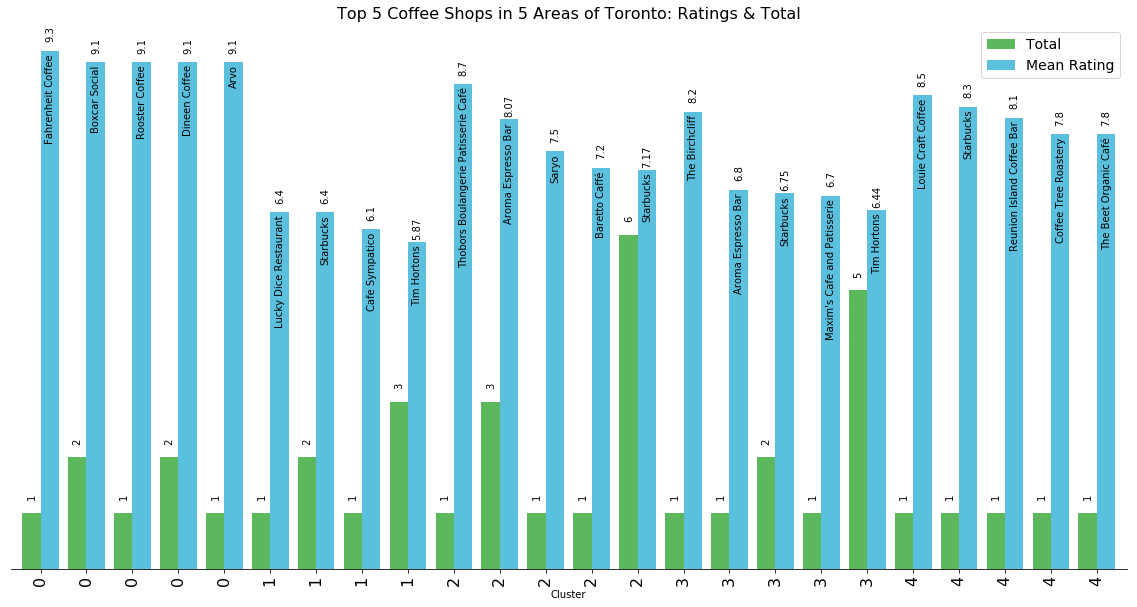

In [227]:
import matplotlib.pyplot as plt
colors = ['#5cb85c','#5bc0de','#d9534f']
labels = np.asarray(top5.Venue.values)

ax = top5.plot(kind='bar',x='Cluster',y=['Total','Mean Rating'], figsize=(20,10), fontsize=16, width=0.8, color=colors,rot=90)
for i in range(len(labels)):
    plt.annotate(labels[i], xy=(i+0.1, top5.iloc[i,2]-0.2), color='black',rotation=90)
    plt.annotate(str(np.round(top5.iloc[i,2],2)), xy=(i+0.1, top5.iloc[i,2]+0.3), color='black',rotation=90)
    plt.annotate(str(np.round(top5.iloc[i,1],2)), xy=(i-0.3, top5.iloc[i,1]+0.2), color='black',rotation=90)

ax.set_title('Top 5 Coffee Shops in 5 Areas of Toronto: Ratings & Total',fontsize=16)
ax.legend(fontsize=14)
#ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.spines['left'].set_visible(False)  
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)    
ax.axes.get_yaxis().set_ticks([])
plt.show()
